# CNN Model for Cyberbullying Detection

Multi-filter CNN for identifying cyberbullying patterns in social media posts

In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import time

from src.models import SimpleCNN
from src.utils import train_epoch, evaluate, get_predictions, calculate_metrics
from src.train import clean_text, build_vocab, TextDataset
from torch.utils.data import DataLoader

In [2]:
df = pd.read_csv("../data/raw/train.csv")
print(f"Total samples: {len(df)}")

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(f"\nLabel distribution:")
print(df[label_cols].sum())

Total samples: 159571

Label distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [3]:
df["clean_text"] = df["comment_text"].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"].values, df[label_cols].values,
    test_size=0.2, random_state=42
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 127656, Test: 31915


In [4]:
vocab = build_vocab(X_train, max_vocab=10000)
print(f"Vocab size: {len(vocab)}")

Vocab size: 10000


In [5]:
MAX_LEN = 100
BATCH_SIZE = 64

train_dataset = TextDataset(X_train, y_train, vocab, max_len=MAX_LEN)
test_dataset = TextDataset(X_test, y_test, vocab, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Model Architecture

CNN with multiple filter sizes (3, 4, 5) for capturing n-gram patterns

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = SimpleCNN(
    vocab_size=len(vocab),
    embedding_dim=100,
    n_filters=100,
    filter_sizes=[3, 4, 5],
    output_dim=len(label_cols),
    dropout=0.5
).to(device)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters())}")

Device: cpu

Model parameters: 1122106


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

n_epochs = 10
train_losses = []
test_losses = []
train_accs = []
test_accs = []

start_time = time.time()

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1:02d} | Train Loss: {train_loss:.3f} Acc: {train_acc:.3f} | Test Loss: {test_loss:.3f} Acc: {test_acc:.3f}')

train_time = time.time() - start_time
print(f"\nTraining time: {train_time:.2f}s")

Epoch 01 | Train Loss: 0.084 Acc: 0.974 | Test Loss: 0.059 Acc: 0.980
Epoch 02 | Train Loss: 0.060 Acc: 0.980 | Test Loss: 0.055 Acc: 0.981
Epoch 03 | Train Loss: 0.054 Acc: 0.981 | Test Loss: 0.054 Acc: 0.981
Epoch 04 | Train Loss: 0.051 Acc: 0.982 | Test Loss: 0.053 Acc: 0.982
Epoch 05 | Train Loss: 0.048 Acc: 0.983 | Test Loss: 0.054 Acc: 0.982
Epoch 06 | Train Loss: 0.045 Acc: 0.984 | Test Loss: 0.056 Acc: 0.982
Epoch 07 | Train Loss: 0.043 Acc: 0.985 | Test Loss: 0.058 Acc: 0.981
Epoch 08 | Train Loss: 0.040 Acc: 0.986 | Test Loss: 0.059 Acc: 0.982
Epoch 09 | Train Loss: 0.038 Acc: 0.986 | Test Loss: 0.063 Acc: 0.981
Epoch 10 | Train Loss: 0.036 Acc: 0.987 | Test Loss: 0.067 Acc: 0.981

Training time: 11565.33s


In [8]:
torch.save(model.state_dict(), '../outputs/cnn_model.pt')

## Evaluation

In [9]:
y_pred, y_true = get_predictions(model, test_loader, device)
metrics = calculate_metrics(y_true, y_pred, label_cols)

print("Overall Results:")
for k, v in metrics['overall'].items():
    print(f"{k}: {v:.4f}")

print("\nPer-label F1 scores:")
for label in label_cols:
    print(f"{label}: {metrics[label]['f1']:.4f}")

Overall Results:
accuracy: 0.9190
precision: 0.8276
recall: 0.6284
f1: 0.7143

Per-label F1 scores:
toxic: 0.7687
severe_toxic: 0.3504
obscene: 0.7761
threat: 0.3366
insult: 0.6643
identity_hate: 0.3654


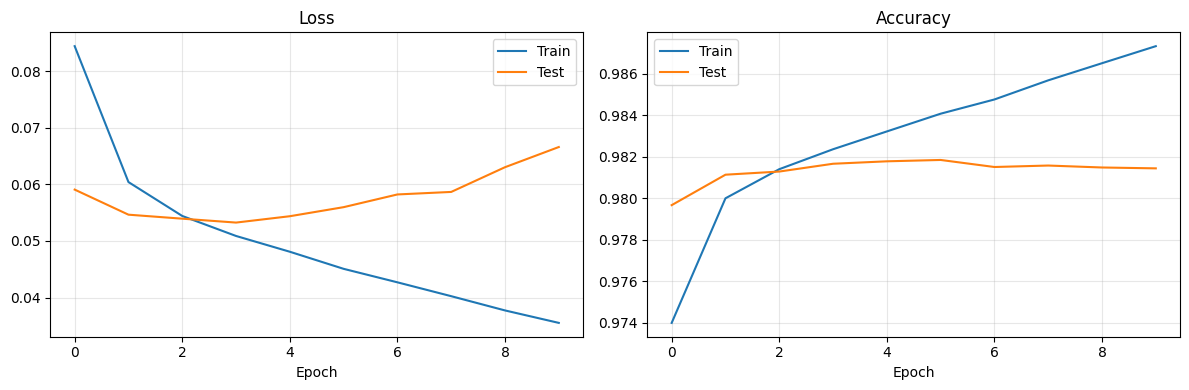

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Train')
axes[0].plot(test_losses, label='Test')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(train_accs, label='Train')
axes[1].plot(test_accs, label='Test')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/cnn_training.png', dpi=150, bbox_inches='tight')
plt.show()

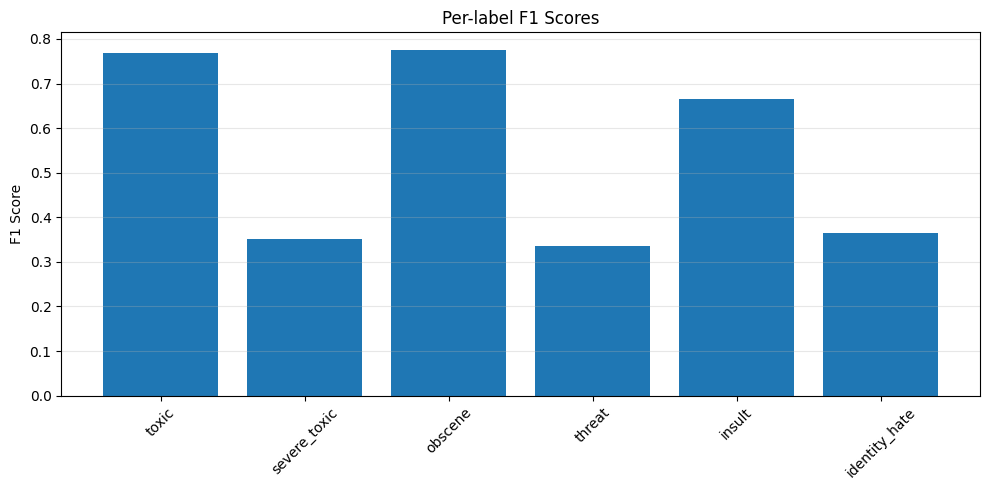

In [11]:
f1_scores = [metrics[label]['f1'] for label in label_cols]

plt.figure(figsize=(10, 5))
plt.bar(label_cols, f1_scores)
plt.title('Per-label F1 Scores')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/cnn_f1_scores.png', dpi=150, bbox_inches='tight')
plt.show()